# Time of computation assessment for ground truth density estimation vs LSH density estimation in high-dimensional spaces

The goal of this notebook is to compare the time taken to compute the ground truth density estimation using cosine similarity against the time taken by the LSH-based density estimation method. This comparison will help illustrate the efficiency of the LSH approach in high-dimensional spaces, especially as the dataset size increases.

In [1]:
import os, sys
sys.path.append(os.path.join(".."))

import numpy as np
import matplotlib.pyplot as plt
import time
import random as rd
from sklearn.metrics.pairwise import cosine_similarity
from lsh_density.lsh_based_kde import run_high_dim_kde, lsh_granularity
from performance_assessment.benchmark_synthetic_data import sample_blobs

## Generating synthetic data...

In [2]:
n_features = 50
total_n_samples = 50000

In [3]:
def generate_synthetic_data(n_features, total_n_samples):
    # Generate a dataset of size n_samples in d dimensions
    all_samples = []
    all_labels = []
    for _ in range(15):
        n_samples = rd.randint(3000, 4500)
        std = rd.uniform(0.1, 1.0)
        clusters_centers = rd.randint(1, 10)
        samples, labels = sample_blobs(n_samples=n_samples, n_features=n_features, clusters_centers=clusters_centers, cluster_std=std, random_state=42, verbose=False)
        all_samples += samples.tolist()
        all_labels += labels

    # Keep only the 20000 first samples - limit for ground truth computation
    all_samples = all_samples[:total_n_samples]
    all_labels = all_labels[:total_n_samples]
    return all_samples, all_labels

The idea here is to plot the time taken for both methods as the number of samples increases, highlighting the efficiency of the LSH approach in high-dimensional spaces.

In [4]:
n_samples_list = [2000, 4000, 6000, 8000, 10000, 15000, 20000]
lsh_times = []
ground_truth_times = []

for n_samples in n_samples_list:
    print(f"\nProcessing {n_samples} samples...")
    all_samples, all_labels = generate_synthetic_data(n_features=n_features, total_n_samples=n_samples)
    all_samples = np.array(all_samples)

    # LSH Density Estimation
    lsh_start_time = time.time()
    lsh_densities = run_high_dim_kde(dataset=all_samples, hash_bits_per_table=20, number_of_hash_tables=30, random_state=42, verbose=True)
    end_time = time.time()
    time_of_lsh = end_time - lsh_start_time
    lsh_times.append(time_of_lsh)
    print(f"LSH density estimation completed in {time_of_lsh:.2f} seconds.")

    theta, cosine_similarity_threshold = lsh_granularity(n_bits=20, p_target=0.5)

    # Ground Truth Density Estimation
    ground_truth_start_time = time.time()
    similarity_matrix = cosine_similarity(all_samples)
    ground_truth_densities = np.sum(similarity_matrix >= cosine_similarity_threshold, axis=1)
    end_time = time.time()
    time_of_ground_truth = end_time - ground_truth_start_time
    ground_truth_times.append(time_of_ground_truth)
    print(f"Ground truth density estimation completed in {time_of_ground_truth:.2f} seconds.")


Processing 2000 samples...
Running LSH-based KDE with 20 hash bits per table and 30 hash tables.
Preparing hash tables and planes...
Hash tables and planes prepared.
Hashing the dataset...
Dataset hashed.
Computing densities for the dataset...
Densities computed.
Computed densities using LSH and SimHash for 2000 samples.
LSH density estimation completed in 0.71 seconds.
Ground truth density estimation completed in 0.03 seconds.

Processing 4000 samples...
Running LSH-based KDE with 20 hash bits per table and 30 hash tables.
Preparing hash tables and planes...
Hash tables and planes prepared.
Hashing the dataset...
Dataset hashed.
Computing densities for the dataset...
Densities computed.
Computed densities using LSH and SimHash for 4000 samples.
LSH density estimation completed in 1.28 seconds.
Ground truth density estimation completed in 0.15 seconds.

Processing 6000 samples...
Running LSH-based KDE with 20 hash bits per table and 30 hash tables.
Preparing hash tables and planes...


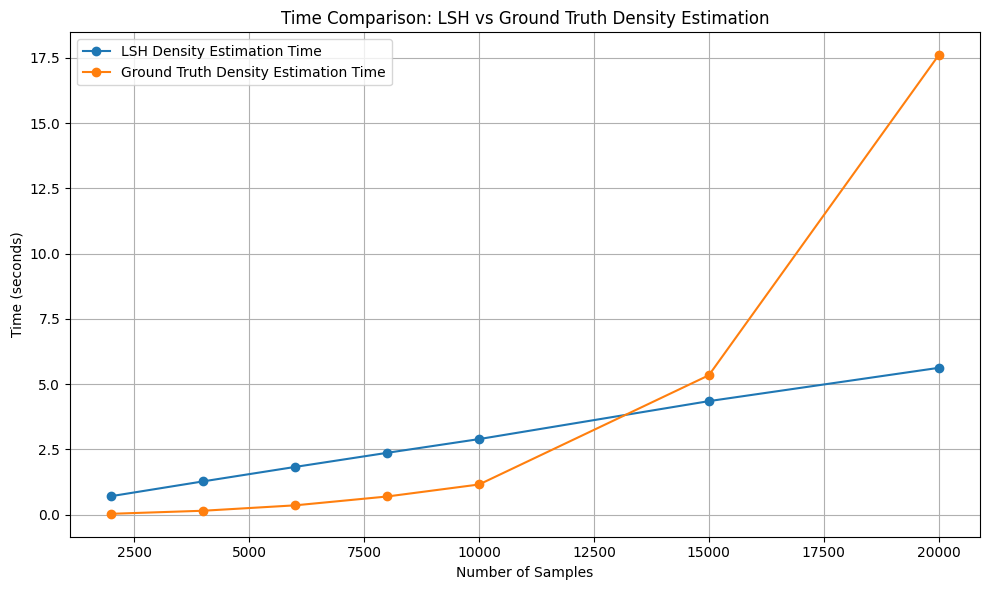

In [8]:
# Plotting the time comparison
plt.figure(figsize=(10, 6))
plt.plot(n_samples_list, lsh_times, marker='o', label='LSH Density Estimation Time')
plt.plot(n_samples_list, ground_truth_times, marker='o', label='Ground Truth Density Estimation Time')
plt.xlabel('Number of Samples')
plt.ylabel('Time (seconds)')
plt.title('Time Comparison: LSH vs Ground Truth Density Estimation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("../results/plots/time_comparison_lsh_vs_ground_truth.png")

The graph above shows the time taken for both the ground truth density estimation and the LSH-based density estimation as the number of samples increases.
Let be: 
- $f$ the function that maps the number of samples to the time taken by the ground truth method
- $g$ the function that maps the number of samples to the time taken by the LSH method

Though the number of samples ranges only from 2000 to 20000 samples (due to computational constraints), we can still observe that $f$ grows significantly faster than $g$, especially as the number of samples increases. Indeed, the ground truth method involves computing pairwise cosine similarities, which has a time complexity of $O(n^2)$, where $n$ is the number of samples, meanwhile the LSH method has a lower time complexity due to its hashing mechanism. The $g$ function seems to grow almost linearly with the number of samples, indicating that the LSH method scales much better with larger datasets.

Somewhere around 13000 samples, the time taken by both methods intersects, indicating that for datasets larger than this size, the LSH method becomes significantly more efficient than the ground truth method. This also means that for smaller datasets, the overhead of setting up the LSH structure takes unnecessarily more time than simply computing the ground truth. Still, we can note that the computation time for the LSH method remains relatively low (and close from) the time taken for the ground truth method for small datasets, making it a viable option even when the dataset size is not very large.